In [1]:
import sys

sys.path.append("..")

import os
import subprocess
from collections.abc import Iterable
from glob import glob
from os.path import dirname, join
from statistics import mode

import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim
from IPython.display import HTML, display
from joblib import Parallel, delayed
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FuncFormatter
from millify import millify
from PIL import Image
from pyproj import Transformer
from skimage.color import label2rgb
from skimage.measure import find_contours, label
from tqdm import tqdm

from pred2raster import pred2raster
from sample_selection import get_components_stats
from src.io_operations import (fix_relative_paths, get_image_metadata,
                               get_image_pixel_scale, load_args, read_tiff,
                               read_yaml)
from utils import *

import warnings
warnings.filterwarnings('ignore')
import textwrap
from seaborn import color_palette
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm


In [2]:
DEFAULT_TITLE_SIZE = 10
DEFAULT_FONT_SIZE = 7

# Style plots
sns.set_theme(style="whitegrid")

# set figsize
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 200

plt.rc('xtick', labelsize=DEFAULT_FONT_SIZE)  
plt.rc('ytick', labelsize=DEFAULT_FONT_SIZE)

# Dict to store colors
dict_colors = {}

# Parallel jobs to load m etrics
N_JOBS = 25

In [3]:
FIG_PATH = join("figures")
os.makedirs(FIG_PATH, exist_ok=True)

# Repo with training data
INPUT_PATH = "../amazon_input_data"

# repo with model outputs
VERSION_FOLDER = "13_amazon_data"
DATA_PATH = join(dirname(os.getcwd()), VERSION_FOLDER)

# load args from the version
args = load_args(join(DATA_PATH, "args.yaml"))

In [4]:
id_tree = pd.read_csv(join(INPUT_PATH,"id_trees.csv"), index_col="label_num")["tree_name"].sort_values()
id_tree.replace({"Angico Angico":"Angico"}, inplace=True)
id_tree.replace({"Cedro Cedro":"Cedro"}, inplace=True)


In [5]:

TEST_GT = read_tiff("../amazon_input_data/segmentation/test_set.tif")

In [6]:
# /home/luiz.luz/multi-task-fcn/13_amazon_data/iter_001/prob_map_test.npy
important_prob_maps= [
    join(DATA_PATH, "iter_001", "prob_map_test.npy"),
    join(DATA_PATH, "iter_008", "prob_map_test.npy"),
    join(DATA_PATH, "iter_020", "prob_map_test.npy"),
]

In [26]:
for ref in range(1, 18):
    print(ref)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [7]:
metrics = []

for prob_map_path in important_prob_maps:
    
    prob_map = np.load(prob_map_path)
    
    for ref in range(1, 18):
        
        prob_map_ref = prob_map[..., ref-1].copy()
        
        ref_test_filter = TEST_GT == ref
        
        metrics.append({
            "prob_map_path": prob_map_path,
            "ref": ref,
            "q25": np.quantile(prob_map_ref[ref_test_filter], 0.25),
            "median": np.median(prob_map_ref[ref_test_filter]),
            "q75": np.quantile(prob_map_ref[ref_test_filter], 0.75),
            "mean": prob_map_ref[ref_test_filter].mean(),
            "std": prob_map_ref[ref_test_filter].std(),
            "min": prob_map_ref[ref_test_filter].min(),
            "max": prob_map_ref[ref_test_filter].max(),
            "pixels_count": ref_test_filter.sum(),
            "sum_prob": prob_map_ref[ref_test_filter].sum()
        })    
        
        
    
    
    
    

In [8]:
df_metrics = pd.DataFrame(metrics) 
df_metrics["iter"] = df_metrics["prob_map_path"].apply(lambda x: int(x.split("/")[-2].split("_")[-1]))

df_metrics.to_parquet(join(DATA_PATH, "dist_prob_from_ref_metrics.parquet"))

In [29]:
df_dist_map = df_metrics.groupby(["iter"], as_index=False)[["pixels_count", "sum_prob"]].sum()
df_dist_map["mean_prob"] = df_dist_map["sum_prob"] / df_dist_map["pixels_count"]
df_dist_map["mean_prob"] = df_dist_map["mean_prob"] / 255
df_dist_map["sum_prob"] = df_dist_map["sum_prob"] / 255


In [30]:
df_dist_map

,iter,pixels_count,sum_prob,mean_prob
0,1,25169385,1.421588e+07,0.564808
1,8,25169385,1.398954e+07,0.555816
2,20,25169385,1.414244e+07,0.561891


In [36]:
df_dist_map = df_metrics.groupby(["iter", "ref"], as_index=False)[["pixels_count", "sum_prob"]].sum()

df_dist_map["mean_prob"] = df_dist_map["sum_prob"] / df_dist_map["pixels_count"]

df_dist_map["tree_name"] = df_dist_map["ref"].map(id_tree)



,iter,ref,pixels_count,sum_prob,mean_prob
0,1,1,4967740,854344263,171.978458
1,1,2,215861,7413642,34.344518
2,1,3,1438947,233268338,162.110445
3,1,4,4869328,899545951,184.737186
4,1,5,1371498,229113570,167.053521
5,1,6,289402,10131888,35.009737
6,1,7,1258167,129313597,102.779358
7,1,8,1953094,215103218,110.134596
8,1,9,528791,71695887,135.584545
9,1,10,415009,30637660,73.824086


<Axes: xlabel='ref', ylabel='mean_prob'>

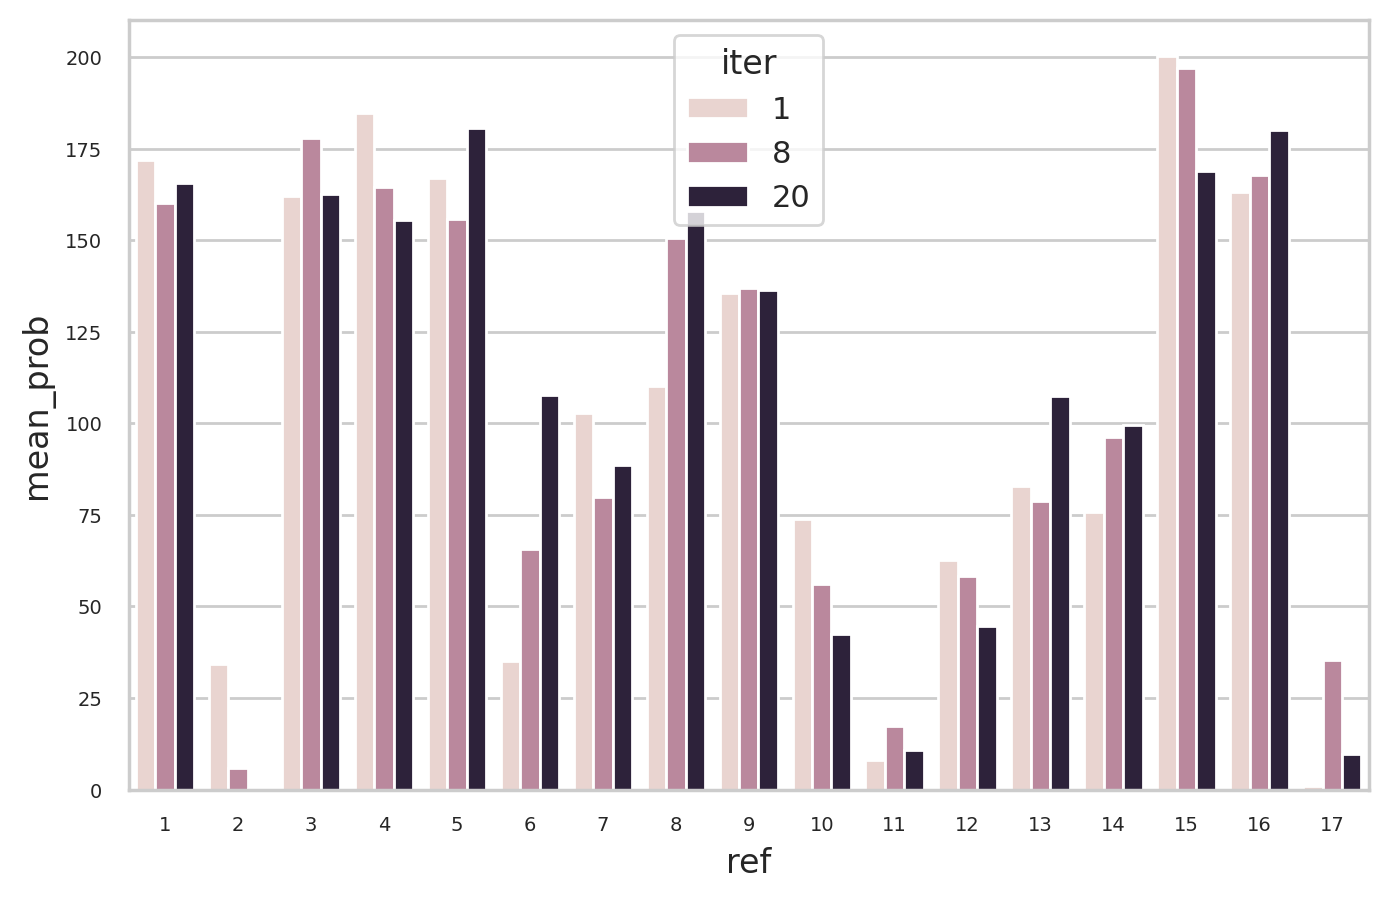

In [37]:
sns.barplot(
    data=df_dist_map,
    x="ref",
    y="mean_prob",
    hue="iter"
)
